In [36]:
import shutil

import pandas as pd
import requests
from gensim.models import KeyedVectors
import json
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patchesb
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [37]:
file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

In [38]:
filtered_vocab_df = pd.read_json("../data/filtered_vocab_df.json")
filtered_vocab_df.head(20)

,word,1501-1550,1551-1600,1601-1650,1651-1700,mean,in_lila_embeddings,in_lasla,in_operamaiora,transl
3299,dico,43255,122549,42457,72224,70121.25,True,True,True,"say, call, tell"
960,pars,33225,93059,44337,52385,55751.50,True,True,True,part
3871,possum,25029,82700,38391,76841,55740.25,True,True,True,"be able, can"
6039,habeo,31690,89199,39443,59770,55025.50,True,True,True,"have, hold, possess, consider, think"
2898,facio,31814,98524,36944,51438,54680.00,True,True,True,"do, make, handle"
5630,liber,39559,65900,38496,53100,49263.75,True,True,True,"book, volume, inner bark of a tree, book, book"
4259,res,29069,70669,28291,51565,44898.50,True,True,True,suddenly
1219,uideo,21536,59099,26372,50503,39377.50,True,True,True,
5787,locus,23102,56782,31421,43680,38746.25,True,True,True,"place, location"
1257,corpus,16979,63171,22871,31938,33739.75,True,True,True,"body, corpus"


In [39]:
len(filtered_vocab_df)

6005

In [40]:
word_transl_dict = dict(zip(filtered_vocab_df["word"], filtered_vocab_df["transl"]))

In [41]:
filtered_vocab_df[filtered_vocab_df["word"].str.contains("equa")]

,word,1501-1550,1551-1600,1601-1650,1651-1700,mean,in_lila_embeddings,in_lasla,in_operamaiora,transl
4021,aequalis,6342,21313,14968,17950,15143.25,True,True,True,"equal, similar, uniform, level, flat, of the s..."
6071,aequator,1133,1723,2795,4088,2434.75,False,False,False,equator
6005,inaequalis,717,2228,1505,1615,1516.25,True,True,True,"uneven, unequal, not smooth/level (surface), i..."
2944,inaequalitas,695,899,803,1336,933.25,True,True,True,"irregularity of shape/distribution, patchiness..."
4725,aequalitas,380,1509,735,1077,925.25,True,True,True,"evenness, equality (of age/status/merit/distri..."
3016,sequax,148,135,109,106,124.50,True,True,True,"that follows closely/eagerly, addicted, pliant..."
105,nequam,19,75,38,58,47.50,True,True,True,"bad, worst"


In [42]:
# translation function if we need to translate some other words
def simple_translation(target):
    try:
        base_url = "https://www.latin-is-simple.com/api/vocabulary/search/?query={}&forms_only=true"
        resp_json = requests.get(base_url.format(target)).json()
        transl = resp_json[0]["translations_unstructured"]["en"]
        if transl == "still in translation":
            transl = ""
        return transl
    except:
        return ""

In [43]:
periods_str = filtered_vocab_df.columns[1:5]
periods_str

Index(['1501-1550', '1551-1600', '1601-1650', '1651-1700'], dtype='object')

In [68]:
with open("/srv/data/tome/noscemus/vectors/vectors_dict_comp.pkl", "rb") as file:
    vectors_dict = pickle.load(file)

In [69]:
vectors_dict.keys()

dict_keys(['NOSCEMUS - 1501-1550', 'NOSCEMUS - 1551-1600', 'NOSCEMUS - 1601-1650', 'NOSCEMUS - 1651-1700', 'NOSCEMUS - Alchemy/Chemistry', 'NOSCEMUS - Astronomy/Astrology/Cosmography', 'NOSCEMUS - Biology', 'NOSCEMUS - Geography/Cartography', 'NOSCEMUS - Mathematics', 'NOSCEMUS - Medicine', 'NOSCEMUS - Meteorology/Earth sciences', 'NOSCEMUS - Physics', 'LASLA', 'Opera Maiora', 'EMLAP'])

In [70]:
def nn_tups_to_transl(nn_tups, shorten_transl=True):
    transl_list = []
    for tup in nn_tups:
        try:    
            transl = word_transl_dict[tup[0]]
        except:
            try: 
                transl = simple_translation(tup[0])
            except:
                transl = ""
        if shorten_transl:
            if len(transl) >= 10:
                transl = transl[:10] + "..."
        transl_list.append(tup[0] + " ({})".format(transl))
    #transl_list = [tup[0] + " ({})".format(word_transl_dict[tup[0]]) for tup in nn_tups]
    transl_list = [e.replace(" ()", "") for e in transl_list]
    return transl_list

In [71]:
nn_tups_to_transl(vectors_dict["LASLA"].most_similar("equus"), shorten_transl=False)

['currus (chariot, light horse vehicle, triumphal chariot, triumph, wheels on plow, cart)',
 'equa (mare)',
 'equito (ride (horseback))',
 'calcar (spur (for horse), spur, incitement, stimulus, spur of a cock)',
 'ceruus',
 'freno (brake, curb, restrain, check)',
 'habena (thong, strap, whip, halter, reins (pl.), direction, management, government)',
 'essedum (war chariot (two wheeled), light traveling carriage)',
 'frenum (bridle/harness/rein/bit, harnessed horses/team, check/restraint/brake, mastery)',
 'frendo (gnash the teeth, grind up small)']

In [72]:
vectors_dict["LASLA"].similarity("equus", "equa")

0.6677204

In [73]:
vectors_dict["LASLA"].similarity("geometria", "scientia")

0.5682637

In [74]:
vectors_dict["Opera Maiora"].similarity("geometria", "scientia")

0.5577459

In [75]:
vectors_dict["NOSCEMUS - 1501-1550"].similarity("geometria", "scientia")

0.5446258

In [76]:
vectors_dict["NOSCEMUS - 1651-1700"].similarity("geometria", "scientia")

0.7492191

In [77]:
np.mean([tup[1] for tup in vectors_dict["LASLA"].most_similar("scientia")])

0.7608603715896607

In [80]:
def get_weighted_similarity(target1, target2):
    weighted_sims = []
    for key in vectors_dict.keys():
        # calculate average similarity value of ten most similar vectors for both target terms
        nn_avr = np.mean([tup[1] for tup in vectors_dict[key].most_similar(target1, topn=1)] + [tup[1] for tup in vectors_dict[key].most_similar(target2, topn=1)])
        # calculate ordinary similarity between the two terms:
        similarity = vectors_dict[key].similarity("scientia", "geometria")
        # caluculate weighted similarity of the two term
        weighted_sim = similarity / nn_avr
        weighted_sims.append({
            "key" : key,
            "weighted_sim" : weighted_sim
        })
    weighted_sims_df = pd.DataFrame(weighted_sims)
    return weighted_sims_df

In [81]:
targets = ["scientia", "geometria"]
weighted_sims_df = get_weighted_similarity(targets[0], targets[1])
weighted_sims_df

,key,weighted_sim
0,NOSCEMUS - 1501-1550,0.760210
1,NOSCEMUS - 1551-1600,0.919477
2,NOSCEMUS - 1601-1650,0.890934
3,NOSCEMUS - 1651-1700,0.924638
4,NOSCEMUS - Alchemy/Chemistry,0.682043
5,NOSCEMUS - Astronomy/Astrology/Cosmography,0.819373
6,NOSCEMUS - Biology,0.850716
7,NOSCEMUS - Geography/Cartography,0.925320
8,NOSCEMUS - Mathematics,0.945080
9,NOSCEMUS - Medicine,0.863004


In [82]:
def get_table_of_nns(target, topn=20, to_csv=False):
    most_similar_by_per = {}
    for key in vectors_dict.keys():
        try:
            nns = [tup[0] for tup in vectors_dict[key].most_similar(target, topn=topn)]
        except:
            nns = [None] * topn
        most_similar_by_per[key] = nns
    most_similar_df = pd.DataFrame(most_similar_by_per)
    if to_csv:
        filename = target + "_nns.csv"
        most_similar_df.to_csv(filename, index=False)
    return most_similar_df

In [83]:
target = "substantia"
get_table_of_nns(target)

,NOSCEMUS - 1501-1550,NOSCEMUS - 1551-1600,NOSCEMUS - 1601-1650,NOSCEMUS - 1651-1700,NOSCEMUS - Alchemy/Chemistry,NOSCEMUS - Astronomy/Astrology/Cosmography,NOSCEMUS - Biology,NOSCEMUS - Geography/Cartography,NOSCEMUS - Mathematics,NOSCEMUS - Medicine,NOSCEMUS - Meteorology/Earth sciences,NOSCEMUS - Physics,LASLA,Opera Maiora,EMLAP
0,corpus,natura,materia,materia,materia,materia,materia,materia,corporeus,insum,materia,materia,distantia,substantifico,qualitas
1,cerebrum,materia,corporeus,concretus,corpus,corporeus,necesse,dissolutio,materia,natura,corpus,corporeus,praestantia,substantiuo,fumosus
2,materia,corpus,corpus,corporeus,natura,corpus,natura,massa,corpus,qualitas,insum,insum,iactantia,substantialis,natura
3,subtilis,necesse,elementum,qualitas,discrepo,separo,elementum,liquor,qualitas,materia,necesse,corpus,constantia,supersubstantialis,actio
4,natura,res,qualitas,corpus,necesse,subsisto,qualitas,mineralis,natura,corpus,res,natura,inconstantia,subsisto,temperatio
5,tunica,dico,natura,separo,elementum,qualitas,insum,humor,insum,tia,natura,qualitas,obseruantia,corpus,materia
6,caro,qualitas,fluidus,insum,permaneo,natura,forma,fluidus,anima,existo,corporeus,forma,excellentia,separo,proprietas
7,uentriculus,modus,alimentum,elementum,separo,anima,facultas,elementum,generatio,particula,dico,res,sycophantia,transubstantio,uirtus
8,humor,possum,assimilo,natura,liquor,insum,sum,gleba,calor,separo,forma,sum,raritas,materia,elementum
9,particula,pars,proprius,spiritualis,proprietas,corporalis,separo,succus,ignis,corporeus,separo,abstraho,differentia,dimensio,separo


In [84]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_equus_v1", 1,1), nns_equus)

In [ ]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_seminarium_v1", 1,1), nns_seminarium)

In [ ]:
target = "scientia"
topn=10
most_similar_by_per = {}
for subcorpus in vectors_dict.keys():
    nns= nn_tups_to_transl(vectors_dict[subcorpus].most_similar(target, topn=topn), shorten_transl=False)
    most_similar_by_per[subcorpus] = nns
nns_fecundus = pd.DataFrame(most_similar_by_per)
nns_fecundus

In [87]:
def cosine_similarity_matrix(kv, wordlist):
    vectors = np.array([kv[word] for word in wordlist])
    # Compute the cosine similarity matrix (normalize and use dot product)
    normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    similarity_matrix = np.dot(normalized_vectors, normalized_vectors.T)
    # Convert to a pandas DataFrame with words as both row and column labels
    similarity_df = pd.DataFrame(similarity_matrix, index=wordlist, columns=wordlist)
    return similarity_df

In [89]:
target = "scientia"
subcorpus = "NOSCEMUS - 1651-1700"
nns = ["scientia"] + [tup[0] for tup in vectors_dict[subcorpus].most_similar(target, topn=topn)]
similarity_df = cosine_similarity_matrix(vectors_dict[subcorpus], nns).round(2)
similarity_df

,scientia,disciplina,cognitio,mathematica,philosophia,ars,notitia,doctrina,geometria,peritia,studiosus
scientia,1.00,0.82,0.80,0.79,0.77,0.77,0.76,0.75,0.75,0.72,0.71
disciplina,0.82,1.00,0.68,0.76,0.77,0.73,0.64,0.79,0.75,0.69,0.74
cognitio,0.80,0.68,1.00,0.65,0.65,0.66,0.89,0.67,0.60,0.70,0.62
mathematica,0.79,0.76,0.65,1.00,0.69,0.62,0.66,0.70,0.80,0.66,0.72
philosophia,0.77,0.77,0.65,0.69,1.00,0.69,0.58,0.76,0.66,0.54,0.72
ars,0.77,0.73,0.66,0.62,0.69,1.00,0.61,0.64,0.68,0.66,0.71
notitia,0.76,0.64,0.89,0.66,0.58,0.61,1.00,0.64,0.60,0.70,0.63
doctrina,0.75,0.79,0.67,0.70,0.76,0.64,0.64,1.00,0.66,0.63,0.68
geometria,0.75,0.75,0.60,0.80,0.66,0.68,0.60,0.66,1.00,0.58,0.67
peritia,0.72,0.69,0.70,0.66,0.54,0.66,0.70,0.63,0.58,1.00,0.67


In [91]:
similarity_df = cosine_similarity_matrix(vectors_dict["NOSCEMUS - 1651-1700"], nns).round(2)
similarity_df

,scientia,disciplina,cognitio,mathematica,philosophia,ars,notitia,doctrina,geometria,peritia,studiosus
scientia,1.00,0.82,0.80,0.79,0.77,0.77,0.76,0.75,0.75,0.72,0.71
disciplina,0.82,1.00,0.68,0.76,0.77,0.73,0.64,0.79,0.75,0.69,0.74
cognitio,0.80,0.68,1.00,0.65,0.65,0.66,0.89,0.67,0.60,0.70,0.62
mathematica,0.79,0.76,0.65,1.00,0.69,0.62,0.66,0.70,0.80,0.66,0.72
philosophia,0.77,0.77,0.65,0.69,1.00,0.69,0.58,0.76,0.66,0.54,0.72
ars,0.77,0.73,0.66,0.62,0.69,1.00,0.61,0.64,0.68,0.66,0.71
notitia,0.76,0.64,0.89,0.66,0.58,0.61,1.00,0.64,0.60,0.70,0.63
doctrina,0.75,0.79,0.67,0.70,0.76,0.64,0.64,1.00,0.66,0.63,0.68
geometria,0.75,0.75,0.60,0.80,0.66,0.68,0.60,0.66,1.00,0.58,0.67
peritia,0.72,0.69,0.70,0.66,0.54,0.66,0.70,0.63,0.58,1.00,0.67


In [92]:
def plot_similarity_matrix(cosine_sim_matrix, title="Cosine Similarity Heatmap"):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cosine_sim_matrix, cmap='Greens')
    fig.colorbar(cax, label='Cosine Similarity')
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel("Words", fontsize=12)
    ax.set_ylabel("Words", fontsize=12)
    ticks = np.arange(len(cosine_sim_matrix.columns))
    ax.set_xticks(ticks)
    ax.set_xticklabels(cosine_sim_matrix.columns, rotation=90, fontsize=10)
    ax.set_yticks(ticks)
    ax.set_yticklabels(cosine_sim_matrix.index, fontsize=10)
    ax.grid(False)
    plt.tight_layout()
    return fig



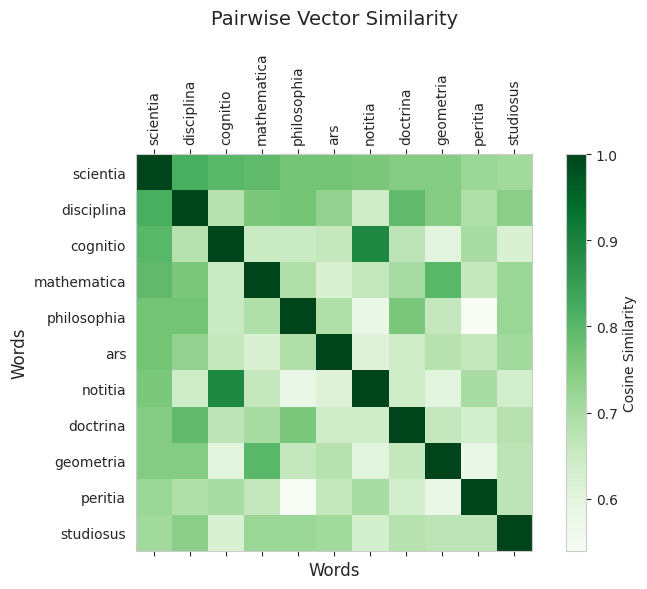

In [93]:
fig = plot_similarity_matrix(similarity_df, title="Pairwise Vector Similarity")

In [94]:
def get_tsne_coors(kv, perplexity=18):
    # inverse similarity to distance
    #data = (1 - sim_matrix) / 1
    words = np.array(kv.index_to_key)
    #data.round(5)
    # tSNE to project all words into a 2-dimensional space
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, metric='cosine', max_iter=1000) # dissimilarity="precomputed",
    #tsne = TSNE(n_components=2, random_state=42, perplexity=18, metric='precomputed', n_iter=5000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(kv.vectors) # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    # extract minimal and maximal values
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words

In [95]:
%%time
# get coordinates for all vectors for all figures below...
coordinates_dict = {}
for key in vectors_dict.keys():
    xs, ys, words = get_tsne_coors(vectors_dict[key])
    coordinates_dict[key] = (xs, ys, words)

CPU times: user 21min 2s, sys: 1min 4s, total: 22min 7s
Wall time: 1min 30s


In [96]:
def get_tsne_coors_d3(kv, perplexity=18):
    words = np.array(kv.index_to_key)
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, metric='cosine', max_iter=1000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(kv.vectors) # project all points into space
    xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
    # extract minimal and maximal values
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    zs = (zs - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

In [ ]:
%%time
# get coordinates for all vectors for all figures below...
coordinates3d_dict = {}
for key in vectors_dict.keys():
    xs, ys, zs, words = get_tsne_coors_d3(vectors_dict[key])
    coordinates3d_dict[key] = (xs, ys, zs, words)

In [ ]:
with open("../data/coordinates3d_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_dict, file)

In [30]:
with open("/srv/webserver/apps/iweems_app/data/coordinates3d_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_dict, file)

In [29]:
#with open("../data/coordinates3d_dict.pkl", "rb") as file:
#    coordinates3d_dict = pickle.load(file)

In [97]:
# experiments with UMAP
import umap
import numpy as np

def get_umap_coors_d3(kv, n_neighbors=30, min_dist=0.3, metric='cosine'):
    words = np.array(kv.index_to_key)
    reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    pos = reducer.fit_transform(kv.vectors)  # Project embeddings into 3D space
    xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
    # Normalize coordinates between 0 and 1
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    zs = (zs - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

In [98]:
%%time
# get coordinates for all vectors for all figures below...
coordinates3d_umap_dict = {}
for key in vectors_dict.keys():
    xs, ys, zs, words = get_umap_coors_d3(vectors_dict[key])
    coordinates3d_umap_dict[key] = (xs, ys, zs, words)

/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/py

CPU times: user 2min 26s, sys: 538 ms, total: 2min 27s
Wall time: 1min 59s


In [99]:
with open("../data/coordinates3d_umap_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_umap_dict, file)

In [101]:
with open("/srv/webserver/apps/iweems_app/data/coordinates3d_umap_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_umap_dict, file)

In [ ]:
target = "scientia"
i = np.where(words == target) # find the positional index
x, y, z = xs[i], ys[i], zs[i] # apply the positional index to navigate through xs and ys
print(x, y, z)

In [ ]:
wordlist = [tup[0] for tup in vectors_dict["1651-1700"].most_similar("scientia", topn=100)]

# TO-DO: save and load to test plotly

In [ ]:
with open("../data/wordlist.json", "w") as file:
    json.dump(wordlist, file)

In [ ]:
def rand_col(seed=0):
    np.random.seed(seed=seed)
    color = np.random.randint(0, 180, size=3)
    color = np.round(color / 256, 2)
    return tuple(color)

In [ ]:
def draw_special_words(ax, wordlist, color="random_color", rotation=True, fontsize=10):
    idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    if isinstance(color, dict):
        colors_dict = color
    elif color=="random_color":
        colors_dict = dict([(w, rand_col(seed=n)) for n, w in enumerate(wordlist)])
    else:
        colors_dict = dict([(w, color) for w in wordlist])
    if rotation:
        rotations = [np.random.randint(0,360) for w in wordlist]
    else:
        rotations = [0 for w in wordlist]
    for x,y,w,r in zip(xs[idx], ys[idx] - 0.003, words[idx], rotations):
        ax.text(x,y,w, horizontalalignment='center', verticalalignment='center', fontsize=fontsize, color=colors_dict[w], zorder=3, rotation=r)

In [ ]:
!mkdir ../figures/large_embeddings/

In [ ]:
%%capture
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    xs, ys, words = get_tsne_coors(kv, perplexity=10)
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=300, tight_layout=True)
    #ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    
    draw_special_words(ax=ax, wordlist=words, color="random_color", fontsize=8)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    fig.savefig("../figures/large_embeddings/embeddings_{}.png".format(key))

In [ ]:
kv = vectors_dict["1651-1700"]
xs, ys, words = get_tsne_coors(kv, perplexity=10)

In [ ]:
special_words = [tup[0] for tup in vectors_dict["1651-1700"].most_similar("scientia", topn=20)]
special_words

In [ ]:
#vectors_dict["lasla"] = lasla
#vectors_dict["operamaiora"] = operamaiora

In [ ]:
['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']

In [ ]:
%%time
# use carefully! - takes time to execute
positions_dict = {}
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    positions_dict[key] = get_tsne_coors(kv, perplexity=8)

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=300, tight_layout=True)

colors_dict = dict([(w, rand_col(seed=n)) for n, w in enumerate(special_words)])

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict, fontsize=10)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)" 
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key) 
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/embeddings_scientia.png")

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
vectors_dict["lasla"].vectors

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit_predict(X=vectors_dict["lasla"].vectors)

In [ ]:
clusters_colors_dict = dict([(i, rand_col(seed=i+0)) for i in range(10)])
words_clustercolors_dict = dict([(w, clusters_colors_dict[clust]) for w, clust in zip(vectors_dict["lasla"].index_to_key, kmeans)])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=600, tight_layout=True)

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    colors_list=[]
    for w in words:
        try:
            colors_list.append(words_clustercolors_dict[w])
        except:
            colors_list.append("black")
    ax.scatter(xs, ys, s=1, color=colors_list, zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    #draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)"
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key)
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/6embeddings_clustercolors_dots.png")

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=300, tight_layout=True)

wordcolor_tups = []
for w in special_words:
    try:
        wordcolor_tups.append((w, words_clustercolors_dict[w]))
    except:
        wordcolor_tups.append((w, "black"))
colors_dict = dict(wordcolor_tups)

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict, fontsize=8)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)"
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key)
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/6embeddings_clustercolors_scientia.png")

In [ ]:
%%capture
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=300, tight_layout=True)
    #ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)

    draw_special_words(ax=ax, wordlist=words, color="random_color", fontsize=5)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    fig.savefig("../figures/large_embeddings/embeddings_{}.png".format(key))